In [66]:
import sys
sys.path.append('bitome2')
from bitome.core import Bitome
from feature_functions import *
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sparse
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, RandomizedSearchCV, LeaveOneOut, train_test_split, KFold
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
import copy
import random
import statistics

In [67]:
bitome_genbank = Bitome('NC_000913.3.gb')
bitome_fasta = Bitome('NC_000913.3.fasta')

# Gene table

In [68]:
gene_table = bitome_genbank.gene_table
gene_table.reset_index(inplace=True)
gene_table

,locus_tag,left,right,strand,pseudo,name
0,b0001,190,255,1,False,thrL
1,b0002,337,2799,1,False,thrA
2,b0003,2801,3733,1,False,thrB
3,b0004,3734,5020,1,False,thrC
4,b0005,5234,5530,1,False,yaaX
...,...,...,...,...,...,...
4493,b4399,4636696,4638120,1,False,creC
4494,b4400,4638178,4639530,1,False,creD
4495,b4401,4639590,4640306,-1,False,arcA
4496,b4402,4640402,4640542,1,False,yjjY


# TU table

In [44]:
tu_table

,Unnamed: 0,locus_tag,name,strand,tss,sigma_factor,box_10_left,box_10_right,box_35_left,box_35_right,left,right
0,0,ECK120008913,astCADBE,-1.0,1832013.0,Sigma70,1832022.0,1832027.0,1832047.0,1832052.0,1825955.0,1832013.0
1,1,ECK120008914,astCADBE,-1.0,1832044.0,Sigma54,1832054.0,1832058.0,1832065.0,1832070.0,1825955.0,1832044.0
2,2,ECK120008915,astCADBE,-1.0,1832039.0,Sigma38,1832046.0,1832056.0,1832070.0,1832075.0,1825955.0,1832039.0
3,3,ECK120008916,nrdHIEF,1.0,2800656.0,Sigma70,2800644.0,2800649.0,2800621.0,2800626.0,2800656.0,2804461.0
4,4,ECK120008917,cpxPQ,1.0,4105785.0,Sigma70,4105772.0,4105777.0,4105746.0,4105751.0,4105785.0,4106379.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3537,3668,ECK125285343,argH,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4156850.0,4158223.0
3538,3669,ECK125285344,aroD,1.0,1774571.0,Sigma70,1774561.0,1774566.0,1774535.0,1774540.0,1774571.0,1775444.0
3539,3670,ECK125285345,yihUTS,-1.0,4073606.0,Sigma70,NaN,NaN,NaN,NaN,4070515.0,4073606.0
3540,3671,ECK125285346,yihW,1.0,4074641.0,Sigma70,NaN,NaN,NaN,NaN,4074641.0,4075454.0


# TFBS table

In [52]:
tfbs = pd.read_csv('TFBS_regulondb.csv')
tfbs

,TF_identifier,TF_name,Confornation_name,TF_binding site_identifier,TF_bs_left_end_position,TF_bs_right_end_position,Strand,TF_Gene_interaction_identifier,Transcription_unit_id_regulated_by_TF,Transcription_unit_name_regulated_by_TF,Gene_expression_effect,Promoter_name,Center_position_TF_bs_relative_to_TSS,TF_bs_sequence,Distance_to_first gene,Evidence_existence,Evidence_confidence_level,Evidence_related_TF_bs_function,Evidence_related_TF_bs
0,ECK125328145,AaeR,AaeR,ECK125258258,NaN,NaN,reverse,ECK125328167,ECK120027580,aaeXAB,+,aaeXp,NaN,NaN,NaN,[GEA|W|Gene expression analysis],Weak,expression,binding in vitro
1,ECK125286586,AccB,AccB,ECK125258258,NaN,NaN,forward,ECK125257898,ECK120009421,accBC,-,accBp1,NaN,NaN,NaN,"[GEA|W|Gene expression analysis],[IMP|W|Inferr...",Weak,expression |,binding in vitro
2,ECK120015994,AcrR,AcrR,ECK125202663,1619048.0,1619058.0,forward,ECK125202664,ECK120009381,marRAB,-,marRp,-40.5,catcggtcaaTTCATTCATTTgacttatact,-67.5,[GEA|W|Gene expression analysis],Weak,expression,binding in vitro | computational prediction
3,ECK120015994,AcrR,AcrR,ECK125242724,1978422.0,1978432.0,reverse,ECK125242725,ECK120009328,flhDC,-,flhDp,-31.5,agcccccctcCGTTGTATGTGcgtgtagtga,-229.5,[GEA|W|Gene expression analysis],Weak,expression,computational prediction
4,ECK120015994,AcrR,AcrR,ECK120035040,2313112.0,2313135.0,forward,ECK120035041,ECK120008981,micF,-,micFp1,41.0,atttattaccGTCATTCATTTCTGAATGTCTGTTtacccctatt,41.0,NaN,NaN,NaN,computational prediction
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4200,ECK120014103,ZraR,ZraR-phosphorylated,ECK120014105,4201811.0,4201827.0,forward,ECK120031168,ECK120009822,zraSR,+,zraSp,-86.0,gctgcgggtaGCGAGTCATTTTTACTCattgaaactt,-107.0,[GEA|W|Gene expression analysis],Weak,expression,HT binding in vivo/ChIP-seq | binding in vitro
4201,ECK120012020,Zur,Zur-Zn<SUP>2+</SUP>,ECK120012022,1942613.0,1942636.0,forward,ECK120051627,ECK120009038,znuCB,-,znuCp,-10.0,atgaatatgaGAAGTGTGATATTATAACATTTCAtgactactgc,-38.0,[GEA|W|Gene expression analysis],Weak,expression,binding in vitro | computational prediction
4202,ECK120012020,Zur,Zur-Zn<SUP>2+</SUP>,ECK120012022,1942613.0,1942636.0,reverse,ECK125141967,ECK120009040,znuA,-,znuAp,38.0,gcagtagtcaTGAAATGTTATAATATCACACTTCtcatattcat,-41.0,"[GEA|W|Gene expression analysis],[BPP|S|Bindin...",Strong,binding in vitro | computational prediction | ...,binding in vitro | computational prediction
4203,ECK120012020,Zur,Zur-Zn<SUP>2+</SUP>,ECK120051670,2041319.0,2041341.0,forward,ECK120051671,ECK120015950,zinT,-,zinTp,-16.0,tgcattttgcTATATGTTACAATATAACATTACacatcatata,-45.0,NaN,NaN,NaN,computational prediction


# Crp motif scores

In [46]:
tf_pwm_db = rpwm('motif_pwm_db.txt')
crp_pwm_old = tf_pwm_db['Crp']
crp_pssm = {base: [pos_dict[base] for pos_dict in crp_pwm_old] for base in 'ATCG'}

In [47]:
import math
score_crp=[]
location_left =[]
location_right = []
for i,j in zip(tu_table['strand'],tu_table['tss']):
    if i == 1.0 and j.is_integer():
       # print(i,j,(bitome_fasta.motif_search(j-300, j+50, 1, crp_pssm, n_best_matches=1)))
        score_crp.append("{:.2f}".format(float(bitome_fasta.motif_search(j-100, j+50, 1, crp_pssm, n_best_matches=1)['log_odds'])))
        location_left.append("{:.2f}".format(float(bitome_fasta.motif_search(j-100, j+50, 1, crp_pssm, n_best_matches=1)['left'])))
        location_right.append("{:.2f}".format(float(bitome_fasta.motif_search(j-100, j+50, 1, crp_pssm, n_best_matches=1)['right'])))
    if i == -1.0 and j.is_integer():
       # print(i,j,(bitome_fasta.motif_search(j-300, j+50, 1, crp_pssm, n_best_matches=1)))
        score_crp.append("{:.2f}".format(float(bitome_fasta.motif_search(j-50, j+100, -1, crp_pssm, n_best_matches=1)['log_odds'])))
        location_left.append("{:.2f}".format(float(bitome_fasta.motif_search(j-100, j+50, 1, crp_pssm, n_best_matches=1)['left'])))
        location_right.append("{:.2f}".format(float(bitome_fasta.motif_search(j-100, j+50, 1, crp_pssm, n_best_matches=1)['right'])))
    if not j.is_integer():
       # print(0)
        score_crp.append(0)
        location_left.append(0)
        location_right.append(0)
        
#print(len(score_crp))
tu_table['Crp'] = score_crp
tu_table['location_left'] = location_left
tu_table['location_right'] = location_right

# Grouping by promoter

In [77]:
import pandas as pd

df1 = gene_table
df2 = tu_table

# Assuming you have two dataframes df1 and df2

# Create an empty list to store the matching rows
matches = []

# Iterate through each row in df1
for index1, row1 in df1.iterrows():
    for index2, row2 in df2.iterrows():
        if (
            (row1['strand'] == 1 and row1['left'] >= row2['left'] and row1['right'] <= row2['right']) or
            (row1['strand'] == -1 and row1['left'] >= row2['left'] and row1['right'] <= row2['right'])
        ):
            matches.append([row1['locus_tag'], row1['left'], row1['right'], row1['name'], row2['name'], row2['Crp']])

# Create a new dataframe from the matches list
result_df = pd.DataFrame(matches, columns=['locus_tag', 'left', 'right', 'name', 'promoter', 'Crp'])

# Print the result
print(result_df)


     locus_tag     left    right  name promoter   Crp
0        b0001      190      255  thrL  thrLABC  7.00
1        b0001      190      255  thrL     thrL  7.00
2        b0002      337     2799  thrA  thrLABC  7.00
3        b0003     2801     3733  thrB  thrLABC  7.00
4        b0004     3734     5020  thrC  thrLABC  7.00
...        ...      ...      ...   ...      ...   ...
6171     b4402  4640402  4640542  yjjY     arcA  0.90
6172     b4402  4640402  4640542  yjjY     arcA  2.90
6173     b4402  4640402  4640542  yjjY     arcA  0.90
6174     b4402  4640402  4640542  yjjY      NaN     0
6175     b4403  4640942  4641628  yjtD      NaN     0

[6176 rows x 6 columns]


In [78]:
result_df_no_duplicates = result_df.drop_duplicates()
print(result_df_no_duplicates)

     locus_tag     left    right  name promoter   Crp
0        b0001      190      255  thrL  thrLABC  7.00
1        b0001      190      255  thrL     thrL  7.00
2        b0002      337     2799  thrA  thrLABC  7.00
3        b0003     2801     3733  thrB  thrLABC  7.00
4        b0004     3734     5020  thrC  thrLABC  7.00
...        ...      ...      ...   ...      ...   ...
6170     b4402  4640402  4640542  yjjY     arcA  1.60
6171     b4402  4640402  4640542  yjjY     arcA  0.90
6172     b4402  4640402  4640542  yjjY     arcA  2.90
6174     b4402  4640402  4640542  yjjY      NaN     0
6175     b4403  4640942  4641628  yjtD      NaN     0

[5799 rows x 6 columns]


# Cluster list

In [79]:
import pandas as pd

# Create a dictionary to map unique promoter values to numbers
promoter_to_number = {}
current_number = 1

promoter_numbers = []

for promoter in result_df_no_duplicates['promoter']:
    if promoter not in promoter_to_number:
        promoter_to_number[promoter] = current_number
        current_number += 1
    promoter_numbers.append(promoter_to_number[promoter])

# Create a new column 'promoter_number' in the DataFrame
result_df_no_duplicates['promoter_number'] = promoter_numbers

# Create a list of the promoter numbers
promoter_number_list = result_df_no_duplicates['promoter_number'].tolist()

# Print the DataFrame and the list of promoter numbers
print(result_df_no_duplicates)
print(promoter_number_list)


     locus_tag     left    right  name promoter   Crp  promoter_number
0        b0001      190      255  thrL  thrLABC  7.00                1
1        b0001      190      255  thrL     thrL  7.00                2
2        b0002      337     2799  thrA  thrLABC  7.00                1
3        b0003     2801     3733  thrB  thrLABC  7.00                1
4        b0004     3734     5020  thrC  thrLABC  7.00                1
...        ...      ...      ...   ...      ...   ...              ...
6170     b4402  4640402  4640542  yjjY     arcA  1.60             1738
6171     b4402  4640402  4640542  yjjY     arcA  0.90             1738
6172     b4402  4640402  4640542  yjjY     arcA  2.90             1738
6174     b4402  4640402  4640542  yjjY      NaN     0                3
6175     b4403  4640942  4641628  yjtD      NaN     0                3

[5799 rows x 7 columns]
[1, 2, 1, 1, 1, 3, 3, 3, 4, 3, 3, 3, 5, 6, 6, 6, 6, 6, 6, 3, 3, 3, 3, 7, 7, 7, 7, 8, 3, 3, 9, 10, 10, 11, 11, 11, 10, 12, 1


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [86]:
cluster_list = promoter_number_list

# Target labels

In [144]:
Crp1_gene_table = pd.read_csv('Crp1_gene_table.csv')
Crp2_gene_table = pd.read_csv('Crp2_gene_table.csv')
locus_tags_with_crp1 = list(Crp1_gene_table.loc[Crp1_gene_table['Crp'], 'locus'])
locus_tags_with_crp2 = list(Crp2_gene_table.loc[Crp2_gene_table['Crp'], 'locus'])
locus_tags = locus_tags_with_crp1 + locus_tags_with_crp2
print(list(set(locus_tags)))

['b2149', 'b3081', 'b4067', 'b3748', 'b1617', 'b4240', 'b2957', 'b1819', 'b1205', 'b3403', 'b2094', 'b2535', 'b3092', 'b2150', 'b2239', 'b2844', 'b2091', 'b3134', 'b3132', 'b4139', 'b0598', 'b2095', 'b3708', 'b3599', 'b0729', 'b3133', 'b3601', 'b1101', 'b4357', 'b2240', 'b2151', 'b3934', 'b0651', 'b2093', 'b3225', 'b3709', 'b3224', 'b2166', 'b2143', 'b3588', 'b4123', 'b1415', 'b4069', 'b0723', 'b2148', 'b4267', 'b1818', 'b2096', 'b3600', 'b2597', 'b1817', 'b0721', 'b4068']


In [145]:
target_labels=[]
target_crp = list(set(locus_tags))
for i in result_df_no_duplicates['locus_tag']:
    if i in target_crp:
        target_labels.append(1)
    else:
        target_labels.append(0)
result_df_no_duplicates['target_labels'] = target_labels
target_label={}
target_label['Crp'] = target_labels


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [146]:
result_df_no_duplicates

,locus_tag,left,right,name,promoter,Crp,promoter_number,target_labels
0,b0001,190,255,thrL,thrLABC,7.00,1,0
1,b0001,190,255,thrL,thrL,7.00,2,0
2,b0002,337,2799,thrA,thrLABC,7.00,1,0
3,b0003,2801,3733,thrB,thrLABC,7.00,1,0
4,b0004,3734,5020,thrC,thrLABC,7.00,1,0
...,...,...,...,...,...,...,...,...
6170,b4402,4640402,4640542,yjjY,arcA,1.60,1738,0
6171,b4402,4640402,4640542,yjjY,arcA,0.90,1738,0
6172,b4402,4640402,4640542,yjjY,arcA,2.90,1738,0
6174,b4402,4640402,4640542,yjjY,NaN,0,3,0


# Building the ML model

In [147]:
df_score = result_df_no_duplicates[['Crp']]
X_eng = df_score.values
print(X_eng)
X_eng = StandardScaler().fit_transform(np.array(X_eng).reshape(-1, 1))
X_eng.shape

[['7.00']
 ['7.00']
 ['7.00']
 ...
 ['2.90']
 [0]
 [0]]


(5799, 1)

In [148]:
df_score.set_index(result_df_no_duplicates['locus_tag'], inplace=True)
df_score_stdd = pd.DataFrame(data = X_eng, columns=df_score.columns)

In [149]:
subset_dict = {}
subset_dict['Crp'] = target_crp
search_cluster_df = pd.DataFrame(data=cluster_list, columns=['cluster'], index=df_score.index)
IM_promoters = {}
for IM in subset_dict:
    gene_list = [gene for gene in subset_dict[IM] if gene in list(df_score.index)]
    print(gene_list)
    cluster_df = search_cluster_df.loc[gene_list, 'cluster'] 
    print(cluster_df)
    promoter_list = []
    for cluster_num in pd.unique(cluster_df):
        each_promoter_list = list(cluster_df[cluster_df==cluster_num].index)
        print(each_promoter_list)
        promoter_list.append(each_promoter_list)
        print(promoter_list)
    IM_promoters[IM] = promoter_list
# Grouping all genes into promoters/operons
cluster_df = search_cluster_df['cluster'] 
All_promoters = []
for cluster_num in pd.unique(cluster_df):
    each_promoter_list = list(cluster_df[cluster_df==cluster_num].index)
    All_promoters.append(each_promoter_list)
All_promoters_df = pd.DataFrame(columns=['first_gene', 'genes'], index=range(len(All_promoters)))
ind = 0
for promoter in All_promoters:
    All_promoters_df.iloc[ind, 0] = promoter[0]
    All_promoters_df.iloc[ind, 1] = promoter
    ind += 1 
All_promoters_df.to_csv('gene_groupby_promoter.csv')

['b2149', 'b3081', 'b4067', 'b3748', 'b1617', 'b4240', 'b2957', 'b1819', 'b1205', 'b3403', 'b2094', 'b2535', 'b3092', 'b2150', 'b2239', 'b2844', 'b2091', 'b3134', 'b3132', 'b4139', 'b0598', 'b2095', 'b3599', 'b0729', 'b3133', 'b3601', 'b1101', 'b4357', 'b2240', 'b2151', 'b3934', 'b0651', 'b2093', 'b3225', 'b3224', 'b2166', 'b2143', 'b3588', 'b4123', 'b1415', 'b4069', 'b0723', 'b2148', 'b4267', 'b1818', 'b2096', 'b3600', 'b2597', 'b1817', 'b0721', 'b4068']
locus_tag
b2149     822
b2149     823
b3081       3
b4067    1595
b4067    1596
         ... 
b3600    1388
b2597     996
b1817     708
b0721     272
b4068    1595
Name: cluster, Length: 65, dtype: int64
['b2149', 'b2150', 'b2148']
[['b2149', 'b2150', 'b2148']]
['b2149', 'b2148']
[['b2149', 'b2150', 'b2148'], ['b2149', 'b2148']]
['b3081', 'b2094', 'b2844', 'b2091', 'b2095', 'b4357', 'b0651', 'b2093', 'b2166']
[['b2149', 'b2150', 'b2148'], ['b2149', 'b2148'], ['b3081', 'b2094', 'b2844', 'b2091', 'b2095', 'b4357', 'b0651', 'b2093', 'b21

In [150]:
models_to_try = {
    
#     'SVM': LinearSVC(
#     penalty = 'l1',
#     class_weight='balanced',
#     dual=False,
#     random_state=42,
#     verbose=0,
#     ),
    
    'LR': LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        class_weight='balanced',
        l1_ratio = 0.5,
        random_state=42
    )
    
#     'RF': RandomForestClassifier(
#         class_weight='balanced',
#         random_state=42,
#         verbose=0
#     )
}

In [151]:
print(IM_promoters)

{'Crp': [['b2149', 'b2150', 'b2148'], ['b2149', 'b2148'], ['b3081', 'b2094', 'b2844', 'b2091', 'b2095', 'b4357', 'b0651', 'b2093', 'b2166'], ['b4067', 'b4069', 'b4068'], ['b4067'], ['b3748'], ['b1617'], ['b4240'], ['b2957'], ['b1819', 'b1818', 'b1817'], ['b1205'], ['b3403'], ['b2094', 'b2091', 'b2095', 'b2093', 'b2096'], ['b2535'], ['b3092'], ['b2239', 'b2240'], ['b3134', 'b3132', 'b3133'], ['b4139'], ['b4139'], ['b0598', 'b0598'], ['b3599', 'b3601', 'b3600'], ['b0729'], ['b0729', 'b0723', 'b0721'], ['b1101', 'b1101'], ['b2151'], ['b3934'], ['b3225', 'b3224'], ['b3225'], ['b2143'], ['b3588'], ['b4123', 'b4123'], ['b1415'], ['b0723'], ['b4267'], ['b2597']]}


In [152]:
# from imblearn.under_sampling import ClusterCentroids, CondensedNearestNeighbour
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler, KMeansSMOTE, SVMSMOTE
from imblearn.combine import SMOTETomek
from sklearn.decomposition import PCA
import seaborn as sns

def resample_nfold(oversampler, num_neighbors=5, SMOTE_only = False, exact_repeats_boost=0.1,
                features_table=df_score, target_labels=target_label
                #, undersampler=None
                 ,  final_ratio=1, N_CV=5, random_state=4
                ):
    '''
    oversampler: selected oversampling method from imblearn
    num_neighbor: Number of k-nearest neighbor used to perform SMOTE oversampling
    final_ratio: If undersample=True, the ratio of the n_negative_aftersampling to n_negative_beforesampling.
    
    '''
    
    result_df = pd.DataFrame(
        columns=['model', 'im', 'train_auc', 'test_auc']
    )

    for model_name, model in models_to_try.items():

        for IM_name, y_labels in target_labels.items():          
            # skip the promoters that are too small
            if len(IM_promoters[IM_name])<N_CV:
                continue
            
            #index_num = 0
            print(f'{model_name}: {IM_name}')

            temp_eng_features = features_table.copy()
            temp_eng_features['label'] = y_labels        

            ingroup_set = IM_promoters[IM_name]
            outgroup_set = [l for l in All_promoters if not any(item in l for item in sum(IM_promoters[IM_name], [])) ]

            kf = KFold(n_splits=N_CV)

            train_scores = []
            test_scores = []
            
            for (out_index, in_index) in zip(kf.split(outgroup_set), kf.split(ingroup_set)):
                
                test_promoters_out = sum([outgroup_set[i] for i in out_index[1]], [])          
                train_promoters_out = sum([outgroup_set[i] for i in out_index[0]], [])
                
                test_promoters_in = sum([ingroup_set[i] for i in in_index[1]], [])          
                train_promoters_in = sum([ingroup_set[i] for i in in_index[0]], [])
                
                test_promoters = test_promoters_out + test_promoters_in
                train_promoters = train_promoters_out + train_promoters_in
                
                train_X = temp_eng_features.loc[train_promoters].iloc[:, :-1]
                test_X = temp_eng_features.loc[test_promoters].iloc[:, :-1]

                train_Y = temp_eng_features.loc[train_promoters, 'label']
                test_Y = temp_eng_features.loc[test_promoters, 'label']
            
            
                if SMOTE_only == True:
                    # Only use RandomOverSampling to boost the samples number over num_neighbors+1
                    if len([l for l in train_Y if l==1])<=num_neighbors+1:
                        
                        exact_repeats_boost = (num_neighbors*2)/len([l for l in train_Y if l==0])                
                        rs = RandomOverSampler(sampling_strategy = exact_repeats_boost,random_state=random_state)
                        train_X, train_Y = rs.fit_resample(train_X, train_Y)
                    
                else:
                    # Use RandomOverSampling to boost the positive samples number to a certain pos/neg ratio.
                    rs = RandomOverSampler(sampling_strategy = exact_repeats_boost,random_state=random_state)
                    train_X, train_Y = rs.fit_resample(train_X, train_Y)             
                
                if exact_repeats_boost != 1:
                    # Oversampling by SMOTE
                    if oversampler == SMOTETomek:
                        over = oversampler(sampling_strategy = final_ratio, smote = SMOTE(k_neighbors = num_neighbors),
                                           random_state=random_state)
                        train_X, train_Y = over.fit_resample(train_X, train_Y)
                        
                    else:
                        over = oversampler(sampling_strategy = final_ratio, k_neighbors = num_neighbors,
                                           random_state=random_state)
                        train_X, train_Y = over.fit_resample(train_X, train_Y)
                    

                model.fit(train_X, train_Y)

                if model_name == 'SVM':
                    train_auc = roc_auc_score(train_Y, model.decision_function(train_X))
                    test_auc = roc_auc_score(test_Y, model.decision_function(test_X))

                else:
                    train_auc = roc_auc_score(train_Y, model.predict_proba(train_X)[:,1])
                    test_auc = roc_auc_score(test_Y, model.predict_proba(test_X)[:,1])

                train_scores.append(train_auc)
                test_scores.append(test_auc)
                
                
            sub_result_df = pd.DataFrame(
            data={
                'model': [model_name] * N_CV,
                'im': [IM_name] * N_CV,
                'train_auc': train_scores,
                'test_auc': test_scores
            }

            )

            result_df = pd.concat([result_df,sub_result_df], axis=0)
        

    return result_df

In [153]:
result = resample_nfold(oversampler=SMOTETomek, SMOTE_only = True, num_neighbors=5, target_labels=target_label, 
                              random_state=4)

LR: Crp


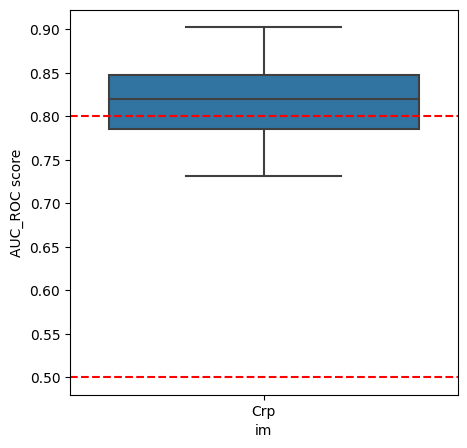

In [154]:
result_LR = result[result['model']=='LR']
plt.figure( figsize=(5,5))
sns.boxplot(x='im', y='test_auc', data=result_LR)
plt.axhline(y= 0.5, color = 'r', ls = '--')
plt.axhline(y= 0.8, color = 'r', ls = '--')
plt.ylabel('AUC_ROC score')
plt.savefig("Crp_AUC_ROC_score.pdf", format="pdf", bbox_inches="tight")


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


locus_tag
b0001    7.0
b0001    7.0
b0002    7.0
b0003    7.0
b0004    7.0
        ... 
b4402    1.6
b4402    0.9
b4402    2.9
b4402    0.0
b4403    0.0
Name: Crp, Length: 5799, dtype: float64
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

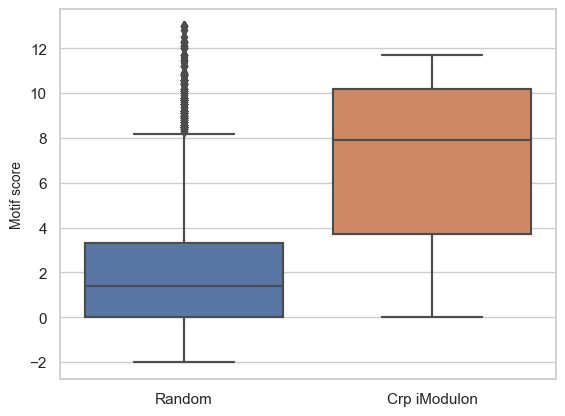

In [163]:
import matplotlib
df_score['Crp'] = pd.to_numeric(df_score['Crp'], errors='coerce')
y = df_score['Crp']
x = target_label['Crp']
for i in range(len(x)):
    if x[i] == 0:
        x[i] = 'Random'
    else:
        x[i] = 'Crp iModulon'
sns.boxplot(x=x,y=y)

sns.boxplot(x=x,y=df_score['Crp'])
plt.ylabel("Motif score", fontsize=10)
plt.savefig("Crp_motif_score_updated.pdf", format="pdf", bbox_inches="tight")